# Quarterly QA on Siemens Scanners

This is performed on the Siemens *long bottle* phantom in the most used head coil - either the standard Head and Neck 25 element coil or the 32 channel head coil. These are used for the Siemens coil QA and it can be easily and reproducibly positioned using the dedicated Siemens foam pad.

Where this phantom is not available (eg on Avanto generation systems) then the slightly wider *short bottle* and its corresponding holder should be used. This variant may be specified in the analysis below.

The bandwidth used should be approximately scaled with the field strength so 130Hz at 1.5T and 260Hz at 3.0T.

The quarterly QA scans consist of the following scans:

 - SE, 2 acquisitions, with/without PSN, multiple elements, RMS coil combine -> SNR, Unif, XY gradient scale
 - SE, 2 acquisitions, without PSN, multiple elements, RMS coil combine, TX switched off by setting reference voltages to zero

and optionally:

 - EPI, 60+ acquisitions, ghosting and long term stability, eddy currents and shim (distortion)

The acquisitions should have the following labels in the protocol to make them easier to identify:

 - `QQA_SE_SIGNAL`
 - `QQA_SE_NOISE`
 - `QQA_EPI_STABILITY`
 
Although we may well have multiple series for each label we should be able to deduce which is which based on the image type, coil names and coil element masks.

In [1]:
from __future__ import division, print_function

# Patient details file yaml/json
import yaml

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from mriqa.phantoms import SIEMENSLONGBOTTLE, SIEMENSSHORTBOTTLE
from mriqa.dcmio import fetch_series, coil_elements
from mriqa.tools import show_montage

from dcmextras.siemenscsa import csa, phoenix

from mriqa.reports import (
    ghosting_report, uniformity_report, noise_correlation_report,
    circularity_report, snr_report_multi
)

### Details of series to analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [2]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)
patid = study_info['PatID']
studyid = study_info['StudyID']
series = study_info['Series']

display(
    pd.DataFrame(
        {'Details':[patid, studyid] + list(series.values())}, 
        index=['Patient', 'Study'] + list(series.keys())
    )
)

Details
Patient          QQA20180425BCHSKYRA
Study                              1
Signal                           [2]
Signal_Combined                  [3]
Noise                            [5]
Noise_Combined                   [6]
Geometry                         [4]

In [3]:
NewPage

### Individual coil element images
These show the images from each element of the array coil before combination. There are expected to be non-uniform and some will be brighter than others according to their sensitivity at the position of the slice. There should however be some intensity in all the images.

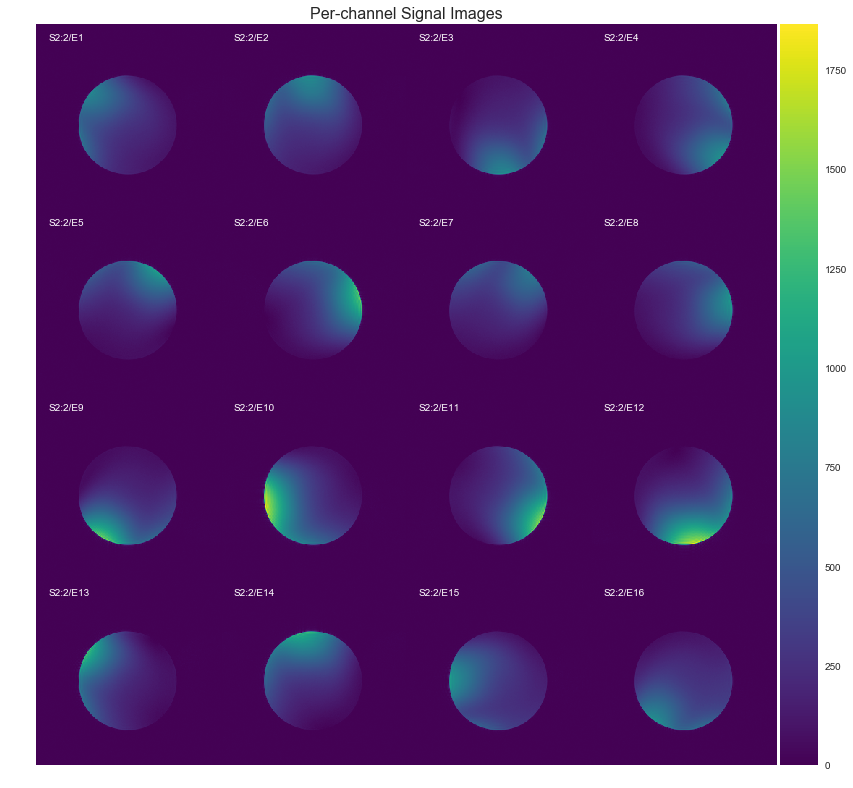

In [4]:
# Assume just one element
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Signal']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

show_montage(dobjsa, dobjsb, op='mean', cmap='viridis', title='Per-channel Signal Images');

In [5]:
NewPage

### Coil Element Noise Images (Zero TX Voltage)
A more rigorous way of investigating the noise is to acquire images with no signal at all. We have set the TX voltage to zero in the System part of the UI. Unfortunately, this is not persistent in the protocol so has to be done each time it is run.

These are the individual noise images. We'll assume that the noise is spatially stationary in each of these images and that, furthermore, it remains so when they are combined as sum-of-squares.

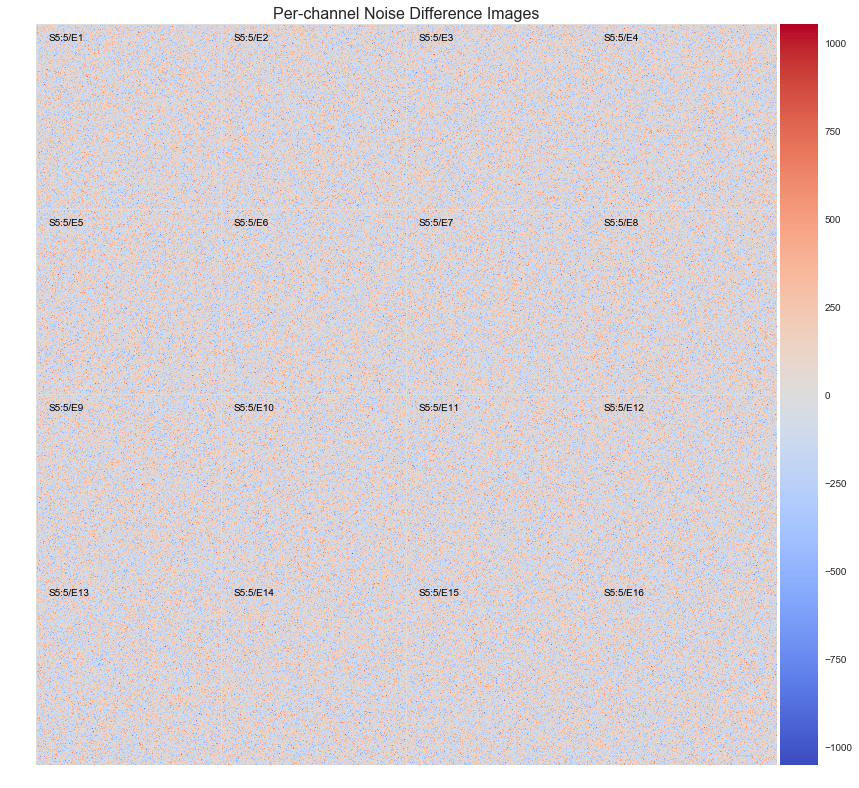

In [6]:
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Noise']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]
show_montage(dobjsa, dobjsb, op='diff', cmap='coolwarm', title='Per-channel Noise Difference Images');

In [7]:
NewPage

## Noise Image Channel Covariance (Crosstalk)
We'll look at the any strong variation in the coil element noise powers that might indicate a broken element. In addition, any significant off-diagonal power indicates an unwanted coupling between the elements.

Ideally we would like to calculate this covariance using the raw complex data. Here we have only the magnitude image data, so for now we'll assume that the covariance matrix is still representative if we take the *difference* of two images for each element.

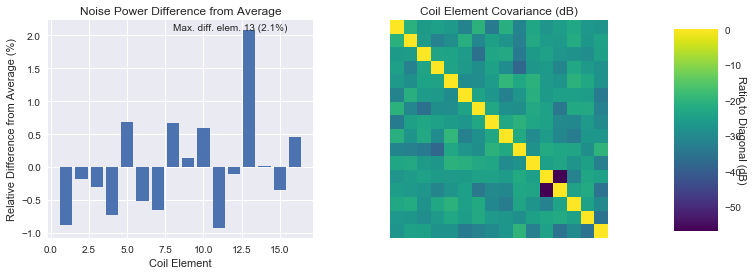

HeadNeck_20
Minumum Correlation           -425.684
Maximum Correlation          41033.084
Variance Along Diagonal          0.007
Maximum Off-Diagonal Term        0.304

In [8]:
with pd.option_context('display.precision', 3):
    display(noise_correlation_report(dobjsa, dobjsb).rename(columns={
     'MinCorrelation': 'Minumum Correlation',
     'MaxCorrelation': 'Maximum Correlation',
     'DiagonalVariance': 'Variance Along Diagonal',
     'MaximumOffDiagonal': 'Maximum Off-Diagonal Term',
    }).T)

In [9]:
NewPage

## Signal to Noise Ratio

Signal to noise ratio using uncombined signal images, which we combine here as some of squares. A current limitation is that this may only work with Siemens where we have multi-series not multi-frames.

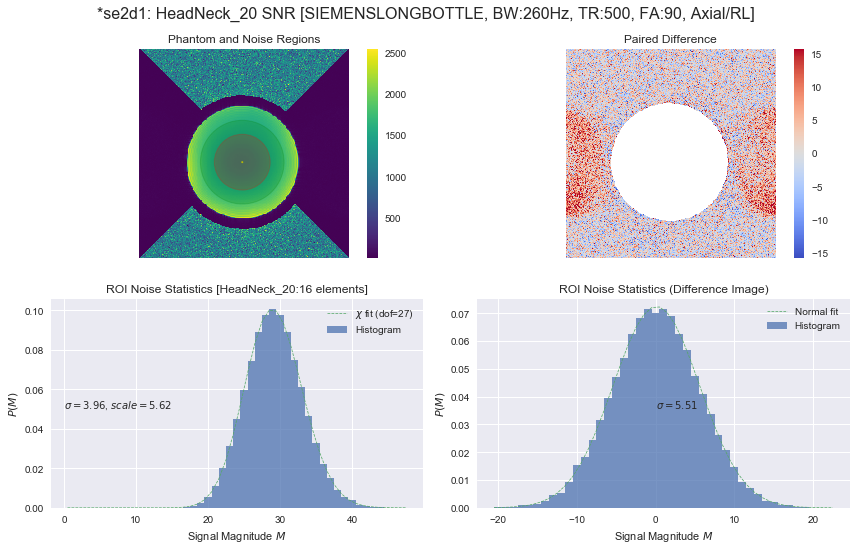

HeadNeck_20
0.50       342.57
0.75       383.69

In [10]:
# SNR (uncombined channels)
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Signal']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

with pd.option_context('display.precision', 2):
    display(snr_report_multi(dobjsa, dobjsb, phantom=SIEMENSLONGBOTTLE))

In [11]:
NewPage

## Geometry
For geometrical measures we want to look at the average of the coil-combined images with *Prescan Normalise* intensity correction applied. This will give us the highest SNR and the most uniform image, which should make the segmentation more robust wthout affecting the image geometry.

### Phantom Circularity (Scale and Distortion)

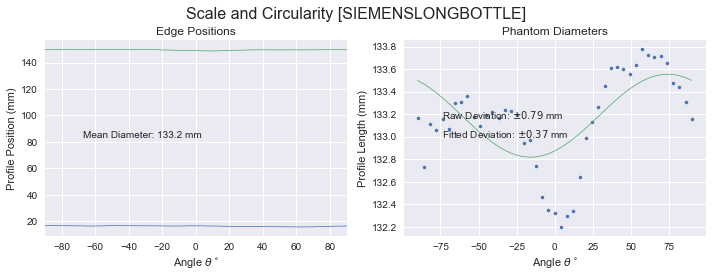

SIEMENSLONGBOTTLE
Nominal                     130.00
Diameter                    133.15
Deviation                     0.79
FittedDeviation               0.37

In [12]:
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Geometry']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber))
)

with pd.option_context('display.precision', 2):
    display(circularity_report(dobjs[0], phantom=SIEMENSLONGBOTTLE).T)

In [13]:
NewPage

### Ghosting
We can use the same routines for ghosting as for the small GE sphere. As the phantom is cylindrical, of course, only the axial plane will be considered.

Note that the actual values obtained for the ghosting ratio will vary somewhat according to exactly where the ghosting regions of interest are defined. In particular, any ringing-like behaviour will only be detected with a ROI close to the phantom. Nyquist ghosting on the other hand is best detected with an ROI that comprises the phantom shifted by N/2 in the *phase encoding* direction.

As the test compares background signal in the phase encoding and the readout direction we are only sensitive to these separately (generally in the phase encoding direction). Anything that is manifest on both axes will cancel out in the subtraction. Possibly a better point of comparison would be the image corners.

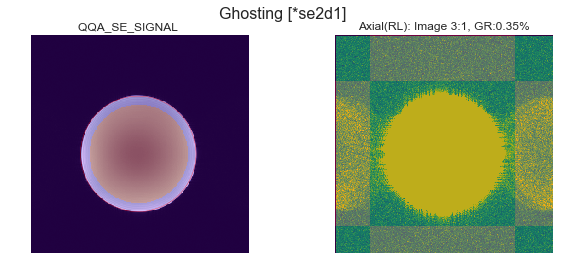

Protocol Orientation Sequence  Ghost Ratio (%)
Series                                                     
3       QQA_SE_SIGNAL       Axial   *se2d1            0.349

In [14]:
# LONGBOTTLE: Ghosting
dobjs = fetch_series(patid, studyid, sernos=series['Signal_Combined'])
results = ghosting_report([dobjs[0]], phantom=SIEMENSLONGBOTTLE)

with pd.option_context('display.precision', 3):
    display(
        results[['Protocol', 'Orientation', 'Sequence', 'GhostRatio']].rename(columns={
            'GhostRatio': 'Ghost Ratio (%)'
        })
    )

In [15]:
NewPage

### Uniformity
These are the same routines for uniformity as for the oil sphere used at acceptance but the phantom is cylindrical so only the axial plane is considered. Note that, at 3T there will be a significant contribution from the $B_1^+$ non-uniformity as well as from the receive coil sensitivities. Only some of this may be compensated for by the prescan normalize option; the scans used to calibrate this may have different sensitivity to flip angle variations. On the other hand this is quite a small phantom so the $B_1^+$ effects may not be very pronounced over such a limited volume.

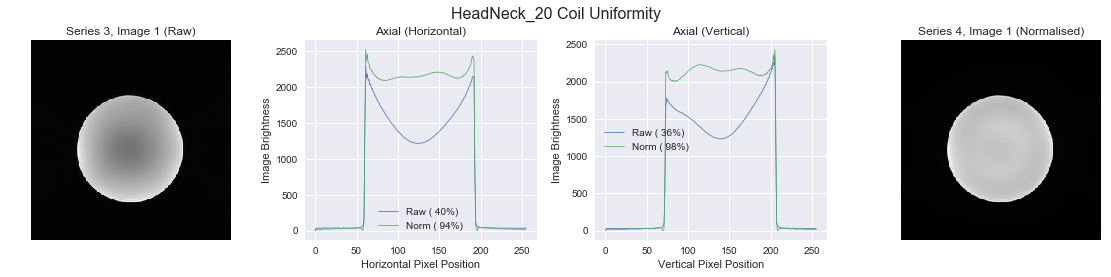

Raw Images


Series No.       Protocol      Axis   X Uniformity (%)  \
Orientation                                                           
Axial                 3  QQA_SE_SIGNAL  Axial/RL              39.55   

             Y Uniformity (%)  
Orientation                    
Axial                   35.56

Intensity Normalised Images


Series No.       Protocol      Axis   X Uniformity (%)  \
Orientation                                                           
Axial                 4  QQA_SE_SIGNAL  Axial/RL              94.03   

             Y Uniformity (%)  
Orientation                    
Axial                   97.78

In [16]:
raw_dobjs = fetch_series(patid, studyid, sernos=series['Signal_Combined'])
psn_dobjs = fetch_series(patid, studyid, sernos=series['Geometry'])
results = uniformity_report(raw_dobjs=raw_dobjs[:1], psn_dobjs=psn_dobjs[:1], phantom=SIEMENSLONGBOTTLE)

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

In [17]:
NewPage

### Frequency Reference and Transmitter Voltage
These are the reference values reported in the DICOM headers.

In [18]:
dobj = raw_dobjs[0]
csa_tags = csa(dobj)
phoenix_tags = phoenix(dobj)

with pd.option_context('display.precision', 3):
    display(pd.DataFrame({
        'ImagingFrequency': [float(dobj.ImagingFrequency)],
        'TransmitterCalibration': [float(csa_tags['TransmitterCalibration'])],
        'TalesReferencePower': [float(csa_tags['TalesReferencePower'])],
        'GradientSensitivityX': [
            float(phoenix_tags['sGRADSPEC.asGPAData[0].flSensitivityX']) * 1e6,
        ],
        'GradientSensitivityY': [
            float(phoenix_tags['sGRADSPEC.asGPAData[0].flSensitivityY']) * 1e6,
        ],
        'GradientSensitivityZ': [
            float(phoenix_tags['sGRADSPEC.asGPAData[0].flSensitivityZ']) * 1e6
        ]
    }, index=['Value']).T)

Value
ImagingFrequency         123.258
TransmitterCalibration   358.174
TalesReferencePower     1986.113
GradientSensitivityX      89.397
GradientSensitivityY      88.636
GradientSensitivityZ      87.530